<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>


# Customize ZoneSpecies

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

In this tutorial we will:
* Introduce species into a Landlab model.
* Set the zones in which the species operate.
* Evolve a landscape and the species over time.
* Explore SpeciesEvolver output data structures.

The configuration of the model in this tutorial loosely follows the fault throw experiment in Lyons et al., in preperation for Earth Surface Dynamics.

## Macroevolution processes built into species

The evolution of the base species is driven by these processes:
* dispersal: geographic range expansion
* speciation: lineage splitting
* extinction: lineage termination

Import modules and set the environment to show plots inline in this notebook.

In [1]:
from landlab.components import SpeciesEvolver
from landlab.components.species_evolution import ZoneSpeciesController, ZoneSpecies
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

/Users/njlyons/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Prepare the grid and components of the model.

Here we use code from the 'Introduction to SpeciesEvolver' tutorial. This code loads a model grid that has steady state topography and sets the top and bottom boundaries to open.

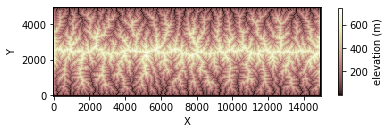

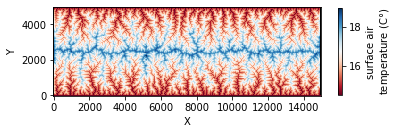

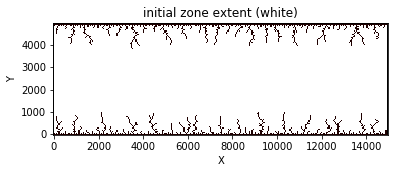

In [21]:
# Prepare the grid and components of the model.

(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                       top_is_closed=False,
                                       left_is_closed=True,
                                       bottom_is_closed=False)

plt.figure()
imshow_grid(mg, z, colorbar_label='elevation (m)', shrink=0.4)

# Set surface temperature at sea level.

temperature_at_sea_level = 14.5
mg.at_node['land_surface_air__temperature'] = 0.006 * mg.at_node['topographic__elevation'] + temperature_at_sea_level

# Plot temperature field.

plt.figure()
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='RdBu')

# Initialize SpeciesEvolver.

se = SpeciesEvolver(mg)

# Create a zone function and plot the initial zone extend.

def zone_func(grid, **kwargs):
    """Get a mask of the total zone extent."""
    T = grid.at_node['land_surface_air__temperature']
    T_min = 15
    T_max = 25
    return np.all([T >= T_min, T <= T_max], 0)

plt.figure()
imshow_grid(mg, zone_func(mg), plot_name='initial zone extent (white)',
            allow_colorbar=False)

## Customize ZoneSpecies

Default implementation of dispersal method:
```python
def _evaluate_dispersal(self, prior_zone, potential_zones):
    """Determine the zones where the species will disperse.

    The default implementation returns all of the potential zones.

    Parameters
    ----------
    prior_zone : Zone
        A zone of the species in the prior time step.
    potential_zones : list of Zones
        The  zones where the species can potentially disperse.

    Returns
    -------
    list of Zones
        The zones where the species will disperse.
    """
    destination_zones = potential_zones
    return destination_zones
```

In [22]:
class MySpecies(ZoneSpecies):
    def _evaluate_dispersal(self, prior_zone, potential_zones):
        # Create an empty list to fill.
        destination_zones = []
        
        for zone in potential_zones:
            if random.random() > 0.5:
                destination_zones.append(zone)
        print(22,destination_zones)
        return destination_zones

### Create a species that exists in the zone

In [23]:
sc = ZoneSpeciesController(se, zone_func, grid=mg)
sc.populate_each_zone(1, species_type=MySpecies)
se.species
#sc.zones

,clade,species_number,time_appeared,latest_time
0,A,0,0,0


22 [<landlab.components.species_evolution.zone.Zone object at 0x1a1bda71d0>]


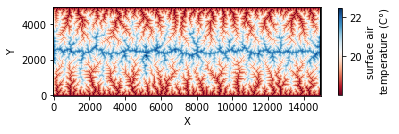

In [24]:
# Update surface temperature at sea level.
temperature_at_sea_level = 18
mg.at_node['land_surface_air__temperature'] = 0.006 * mg.at_node['topographic__elevation'] + temperature_at_sea_level

# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='RdBu')
            
# Advance SpeciesEvolver by one unit of time. Time is dimensionless in this tutorial.
dt = 1
se.run_one_step(dt)
sc.zones

## Model species evolution

First, set model time step and uplift parameters.

SpeciesEvolver runs every 10 timesteps of the other components.

In [6]:
dt = 1000
total_time = int(1e5)
nt = int(total_time // dt)

dt_se = 10 * dt

uplift_rate = 7e-5
uplift_per_step = uplift_rate * dt

Run model. The ```run_one_step``` function of SpeciesEvolver takes the new zones of the time step.

This code block may take a couple minutes to run.

In [ ]:
for time_i in range(nt):
    # Uniformly uplift.
    z[mg.core_nodes] += uplift_per_step

    # Increment earth surface process components.
    fr.run_one_step()
    sp.run_one_step(dt)
    lf.run_one_step(dt)

    elapsed_time = dt * (time_i + 1)

    if elapsed_time % dt_se == 0:
        # Run SpeciesEvolver with updated zones.
        zones = Zone.get_zones_with_area_threshold(mg, min_stream_area)
        se.run_one_step(elapsed_time, zones)

## Plot results



In [ ]:
plt.subplot(1, 2, 1)
imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)')

plt.subplot(1, 2, 2)
plot.imshow_zones(mg, zones)

plot.number_of_species(se.record, se.species)

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>